# **Import modules**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# **Load Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/star_classification.csv")
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

In [ ]:
df['class'].unique()

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [ ]:
input_cols = ['u', 'g', 'r', 'i', 'z', 'redshift']
X = df[input_cols].values  # shape (N, 6)

#  Encode class labels (e.g., STAR=0, GALAXY=1, QSO=2)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])  # shape (N,)

#  Normalize inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
class StarDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(StarDataset(X, y), batch_size=32, shuffle=True)

# **The Router**

In [ ]:
class TopK_Router(nn.Module):
    def __init__(self, inp_dim, n_choices, k=1, return_indices=False):
        super().__init__()
        self.k = k
        self.n_choices = n_choices
        self.linear = nn.Linear(inp_dim, n_choices)
        self.return_indices = return_indices

    def forward(self, x):
        logits = self.linear(x)  # [B, n_choices]
        probs = F.softmax(logits, dim=-1)  # [B, n_choices]
        top_vals, top_idx = torch.topk(probs, self.k, dim=-1)  # [B, k], [B, k]
        top_vals = top_vals / (top_vals.sum(dim=-1, keepdim=True) + 1e-9)  # normalize

        gate = torch.zeros_like(probs).scatter(1, top_idx, top_vals)  # [B, n_choices]

        if self.return_indices:
            return top_idx, top_vals  # for expert tracking
        return gate  # for weighted combination


# **The Expert**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Expert(nn.Module):
    def __init__(self, inp_dim, hid_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inp_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)

class ExpertGroup(nn.Module):
    def __init__(self, inp_dim, hid_dim, out_dim, n_inner_experts):
        super().__init__()
        self.inner_gate = TopK_Router(inp_dim, n_inner_experts)
        self.inner_experts = nn.ModuleList([
            Expert(inp_dim, hid_dim, out_dim) for _ in range(n_inner_experts)
        ])

    def forward(self, x):
        weights = self.inner_gate(x)  # [B, n_inner_experts]
        outputs = torch.stack([expert(x) for expert in self.inner_experts], dim=1)  # [B, n_inner_experts, out_dim]
        return torch.sum(outputs * weights.unsqueeze(-1), dim=1)  # [B, out_dim]


# **The Hierarchical Mixture of Experts**

In [ ]:
class HierarchicalMoE(nn.Module):
    def __init__(self, inp_dim, hid_dim, out_dim, n_outer=4, n_inner=4):
        super().__init__()
        self.outer_gate = TopK_Router(inp_dim, n_outer)
        self.expert_groups = nn.ModuleList([
            ExpertGroup(inp_dim, hid_dim, out_dim, n_inner) for _ in range(n_outer)
        ])

    def forward(self, x):
        outer_weights = self.outer_gate(x)  # [B, n_outer]
        outputs = torch.stack([
            group(x) for group in self.expert_groups  # each: [B, out_dim]
        ], dim=1)  # [B, n_outer, out_dim]
        final_output = torch.sum(outputs * outer_weights.unsqueeze(-1), dim=1)  # [B, out_dim]
        return final_output


# **Training**

In [ ]:
model = HierarchicalMoE(inp_dim=6, hid_dim=128, out_dim=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.2301
Epoch 2, Loss: 0.1449
Epoch 3, Loss: 0.1297
Epoch 4, Loss: 0.1215
Epoch 5, Loss: 0.1161
Epoch 6, Loss: 0.1125
Epoch 7, Loss: 0.1099
Epoch 8, Loss: 0.1085
Epoch 9, Loss: 0.1073
Epoch 10, Loss: 0.1057
Epoch 11, Loss: 0.1049
Epoch 12, Loss: 0.1043
Epoch 13, Loss: 0.1029
Epoch 14, Loss: 0.1026
Epoch 15, Loss: 0.1019
Epoch 16, Loss: 0.1010
Epoch 17, Loss: 0.1007
Epoch 18, Loss: 0.1000
Epoch 19, Loss: 0.0999
Epoch 20, Loss: 0.0989
Epoch 21, Loss: 0.0988
Epoch 22, Loss: 0.0990
Epoch 23, Loss: 0.0980
Epoch 24, Loss: 0.0978
Epoch 25, Loss: 0.0977
Epoch 26, Loss: 0.0974
Epoch 27, Loss: 0.0974
Epoch 28, Loss: 0.0967
Epoch 29, Loss: 0.0966
Epoch 30, Loss: 0.0968
Epoch 31, Loss: 0.0962
Epoch 32, Loss: 0.0958
Epoch 33, Loss: 0.0955
Epoch 34, Loss: 0.0955
Epoch 35, Loss: 0.0947
Epoch 36, Loss: 0.0951
Epoch 37, Loss: 0.0950
Epoch 38, Loss: 0.0950
Epoch 39, Loss: 0.0940
Epoch 40, Loss: 0.0945
Epoch 41, Loss: 0.0942
Epoch 42, Loss: 0.0940
Epoch 43, Loss: 0.0937
Epoch 44, Loss: 0.09

# **Inferencing**

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_hierarchical_expert_usage(model, dataloader, device='cpu'):
    model.eval()
    model.to(device)

    n_outer = len(model.expert_groups)
    n_inner = len(model.expert_groups[0].inner_experts)

    outer_counts = torch.zeros(n_outer, device=device)
    inner_counts = torch.zeros((n_outer, n_inner), device=device)

    with torch.no_grad():
        for xb, _ in dataloader:
            xb = xb.to(device)

            # Outer gate → [B, n_outer], get top-1
            outer_weights = model.outer_gate(xb)
            outer_selected = torch.argmax(outer_weights, dim=1)

            for i, o_idx in enumerate(outer_selected):
                x_single = xb[i:i+1]  # batch of 1

                # Query inner gate from the selected expert group
                inner_weights = model.expert_groups[o_idx].inner_gate(x_single)
                inner_selected = torch.argmax(inner_weights, dim=1)[0]

                outer_counts[o_idx] += 1
                inner_counts[o_idx, inner_selected] += 1

    # === Plotting ===
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Outer expert usage
    ax1.bar(range(n_outer), outer_counts.cpu().numpy())
    ax1.set_title("Outer Expert Usage")
    ax1.set_xlabel("Outer Expert Index")
    ax1.set_ylabel("Count")

    # Inner expert usage per outer expert
    bar_width = 0.8 / n_outer
    x = np.arange(n_inner)
    for outer_idx in range(n_outer):
        ax2.bar(x + outer_idx * bar_width,
                inner_counts[outer_idx].cpu().numpy(),
                width=bar_width,
                label=f'Outer {outer_idx}')
    ax2.set_xticks(x + bar_width * (n_outer / 2))
    ax2.set_xticklabels([f'Inner {i}' for i in range(n_inner)])
    ax2.set_ylabel("Count")
    ax2.set_title("Inner Expert Usage per Outer Expert")
    ax2.legend()

    plt.tight_layout()
    plt.show()


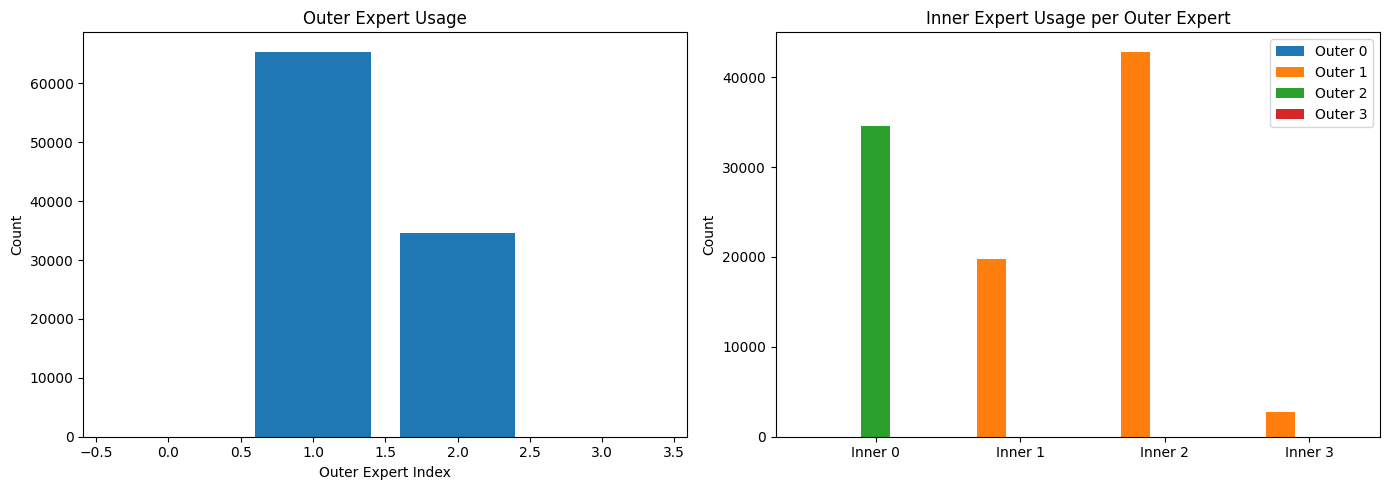

In [ ]:
visualize_hierarchical_expert_usage(model, train_loader, device='cuda' if torch.cuda.is_available() else 'cpu')
